<a href="https://colab.research.google.com/github/Kennedy87670/Introduction-to-ML-DP/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tranfer learning with Tensorflow part 2: fine-tunning
in the previous notebook, we covered transfer learning features extraction, now its time to learn about a new kind of transfer learning: fine-tuning

In [27]:
# check if we are using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Creating helper function

In previous notebooks, we have created a bunch of helper functions, now we could write them all, however this is tedious

So, its a good idea to put functions you will want to use again in a script you can download and import your notebooks (or elsewhere

We have done this for some of the functions we have used previously here 
: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [28]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-20 16:07:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-20 16:07:27 (79.5 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [29]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-07-20 16:07:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-20 16:07:27 (85.8 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



**Note** if you are running this notebook in GOOGLE COLAB, WHEN it times out colab will delete "helper_functions.py", so you will have to redownload it if you want access to the helper functions 


# now lets get some data

This time we are goingto see how we can use the pretrained models within tf.keras.applications and apply 
https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [30]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-07-20 16:07:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.48, 172.217.2.112, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   250MB/s    in 0.6s    

2022-07-20 16:07:28 (250 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [31]:
# check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/gr

In [32]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [33]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode= "categorical",
                                                                            batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [35]:
# check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [36]:
# see an example of batch
for images, labels in train_data_10_percent.take(1):
  print(images)

tf.Tensor(
[[[[3.42251277e+00 7.42251301e+00 6.42251301e+00]
   [3.92857170e+00 7.92857170e+00 8.92857170e+00]
   [2.21428585e+00 3.21428585e+00 7.21428585e+00]
   ...
   [4.16026993e+01 2.56027012e+01 2.56027012e+01]
   [3.96871567e+01 2.36871567e+01 2.36871567e+01]
   [3.70000000e+01 2.30000000e+01 2.20000000e+01]]

  [[4.06728315e+00 8.06728268e+00 7.06728315e+00]
   [3.92857170e+00 7.92857170e+00 8.92857170e+00]
   [1.46906912e+00 3.76339293e+00 7.33195162e+00]
   ...
   [4.06680832e+01 2.46680813e+01 2.46680813e+01]
   [3.94776649e+01 2.34776649e+01 2.34776649e+01]
   [3.75491066e+01 2.35491066e+01 2.25491066e+01]]

  [[4.35714293e+00 8.35714245e+00 7.35714293e+00]
   [3.92857170e+00 7.92857170e+00 8.92857170e+00]
   [6.61033511e-01 4.01817608e+00 7.23246193e+00]
   ...
   [4.05714722e+01 2.45714722e+01 2.45714722e+01]
   [4.08437386e+01 2.48437366e+01 2.48437366e+01]
   [3.92420616e+01 2.52420597e+01 2.42420597e+01]]

  ...

  [[1.88648911e+02 1.81818588e+02 1.53733749e+02]
   [1


## Model 0: Building a transfer learning feature extraction model using keras functional API
The sequential API is staright-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with out models https://www.tensorflow.org/guide/keras/functional

In [37]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model(so the underlying pre-trained patterns arent updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name = "input_layer")

# 4. If using a model like  ResNET50V2 you will need to normalize inputs ( you dont for eficientNET)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"shape AFter passing inputs through base model: {x.shape}")

# 6. Average pol the outputs of the base model (aggregate all the most important information, reduce number of computations)
x =tf.keras.layers.GlobalAveragePooling2D(name ="global_average_pooling_layer")(x)
print(f"Shape afer GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
ouputs = tf.keras.layers.Dense(10, activation='softmax', name= 'ouput_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, ouputs)

#9. Compile the model
model_0.compile(loss ="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                        experiment_name = "10_percent_feature extraction")]
                                 
                                 )

shape AFter passing inputs through base model: (None, 7, 7, 1280)
Shape afer GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature extraction/20220720-160735
Epoch 1/5
24/24 [==============================] - 83s 3s/step - loss: 1.8869 - accuracy: 0.4133 - val_loss: 1.3479 - val_accuracy: 0.7220
Epoch 2/5
24/24 [==============================] - 76s 3s/step - loss: 1.1298 - accuracy: 0.7720 - val_loss: 0.9077 - val_accuracy: 0.8109
Epoch 3/5
24/24 [==============================] - 76s 3s/step - loss: 0.8352 - accuracy: 0.8173 - val_loss: 0.7370 - val_accuracy: 0.8257
Epoch 4/5
24/24 [==============================] - 75s 3s/step - loss: 0.6988 - accuracy: 0.8347 - val_loss: 0.6417 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 76s 3s/step - loss: 0.5835 - accuracy: 0.8587 - val_loss: 0.6051 - val_accuracy: 0.8618


In [38]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 115s 1s/step - loss: 0.6071 - accuracy: 0.8476


[0.6071105003356934, 0.847599983215332]

In [39]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [40]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [41]:
# summary of our model
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 ouput_layer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


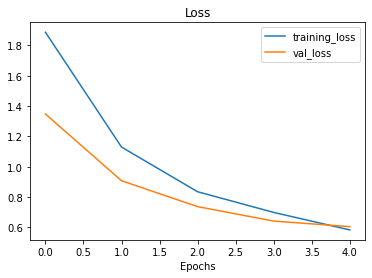

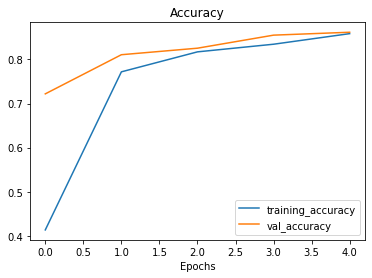

In [42]:
# check out our model training curves
plot_loss_curves(history_10_percent)

## Getting  a feature vector from trained model

lets demonstrate the global Average Pooling 2D layer...

We have a tensor after our model goes through "base_model" of shape (None, 7, 7, 1280)...
But then whenit passes through GlobalAveragePooling2D, it turns into(None, 1280).

lets use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D

In [43]:
#Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape pf Global Average Pooled 2D tensor: {global_average_pooling_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape pf Global Average Pooled 2D tensor: (1, 3)


In [44]:
# lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

** Try to do the same with the above two cells but this time use GlobalMaxPool2D .... and see what happens.

**Note** One of the reasons feature extraction transfer learning is named how it is beacuse what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned represenatation of the model on a particular sample, in our case, this isthe output of the tf.keras.layers.GlobalAveragePooling2D() LAYER)WHICH CAN THEN BE USED TO EXTRACT PATTERNS OUT FOR OUR OWN SPECIFIC PROBLEM

## Running a seriesof transfer learning experiments

We have seen  the increadle result transfer learning can get with only 10% of the training dat, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. "model_1" - use feature extraction transfer learning with 1% of the traiing data with data augmentation
2. "model_2" use feature extraction transfer learning with 10% of the training with data augmentation
3. "model_3" use fine-tunning transfer learning on 10% of the training data with data augmentation
4. 'model_4' use fine-tunning transfer learning on 100% of the training data with data augmentation

Note: throughout all experiments the same test dataset will be used to evalute our model.... this ensures consistency across evalution metrics

## Getting and preprocessing model_1

In [62]:
# Downlaoa and unzip the data - preprocessed data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-07-20 16:26:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.208, 142.251.16.128, 172.253.62.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.3’

10_food_classes_1_p 100%[===================>] 127.42M   284MB/s    in 0.4s    

2022-07-20 16:26:16 (284 MB/s) - ‘10_food_classes_1_percent.zip.3’ saved [133612354/133612354]



In [63]:
# create training and test dir
train_dir_1_percent ="10_food_classes_1_percent/train"
test_dir ="10_food_classes_1_percent/test"

In [64]:
# how many images are we working with?
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There a

In [65]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                          label_mode = "categorical",
                                                                          image_size =IMG_SIZE,
                                                                          batch_size = BATCH_SIZE
                                                                          )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                          label_mode = "categorical",
                                                                          image_size =IMG_SIZE,
                                                                          batch_size = BATCH_SIZE
                                                                          )

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Ading data augumentation right into model

To add data augumenatation right into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()
We can see the benefits of doing this within the Tensorflow data augmentation documentation

Off the top of our heads, after reading the docs, the benefits of using data augmentation inside a model are:
* Preprocessing of image (augmenting them) happens on the GPU (much faster) rather than CPU
* Image data augmentation only happens during training, so we can still export our model and use it elsewhere.

In [66]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#create data augumentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
                                       preprocessing.RandomFlip('horizontal'),
                                       preprocessing.RandomRotation(0.2),
                                       preprocessing.RandomZoom(0.2),
                                       preprocessing.RandomHeight(0.2),
                              preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")



### vISUALIZE OUR DATA AUGMENTATION LAYER (and see what happens to our data)

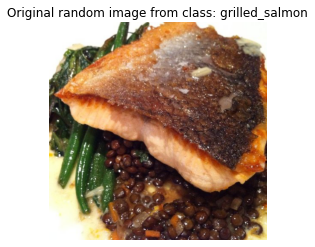

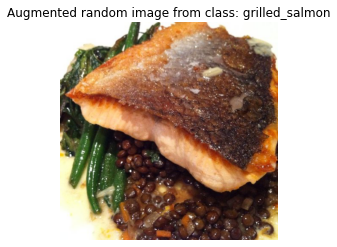

In [68]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: feature extraction transfer learning on 1% of the data with data augmentation

In [72]:
## setup input shape and base model, freezing the base model layers
input_shape= (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create input layers
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation Sequential as a layer
x = data_augmentation(inputs)

# Give base_model the iput (after augmentation) and dont train it
x= base_model(x, training=False)

# Pool output feature of the base model
x = layers.GlobalMaxPooling2D(name="global_average_pooling_layer")(x)

# Put a dense laer on as the output
output = layers.Dense(10, activation="softmax", name= "output_layer")(x)

# make a model with inputs and outputs
model_1 = keras.Model(inputs, output)

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer =tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch= len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                       experiment_name ="1_percent_data_aug")]) 

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220720-172517
Epoch 1/5
3/3 [==============================] - 38s 15s/step - loss: 5.0438 - accuracy: 0.0571 - val_loss: 4.7104 - val_accuracy: 0.1086
Epoch 2/5
3/3 [==============================] - 44s 21s/step - loss: 3.5381 - accuracy: 0.1714 - val_loss: 4.5055 - val_accuracy: 0.1579
Epoch 3/5
3/3 [==============================] - 45s 21s/step - loss: 3.2454 - accuracy: 0.2571 - val_loss: 4.4697 - val_accuracy: 0.1546
Epoch 4/5
3/3 [==============================] - 45s 22s/step - loss: 2.8800 - accuracy: 0.2857 - val_loss: 3.6246 - val_accuracy: 0.2253
Epoch 5/5
3/3 [==============================] - 32s 15s/step - loss: 2.2940 - accuracy: 0.4143 - val_loss: 3.2382 - val_accuracy: 0.2632


In [74]:
#check the summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalMaxPooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [75]:
# evaluate on all the test data
result_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 126s 2s/step - loss: 3.1912 - accuracy: 0.2684


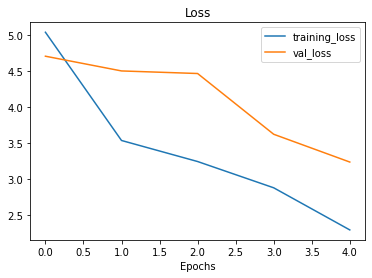

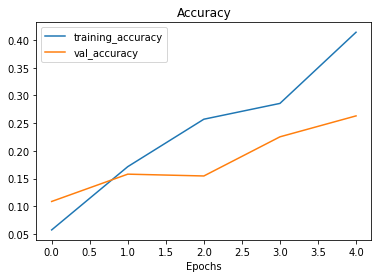

In [76]:
# how does the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)